In [16]:
import pandas as pd
import numpy as np
import os
import seaborn as sns

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image
import scipy.io as sio
import imageio.v2 as imageio

Download dataset

In [6]:
!curl http://graphics.cs.cmu.edu/projects/historicalColor/HistoricalColor-ECCV2012-DecadeDatabase.tar > ../DATA/HistoricalColor-ECCV2012-DecadeDatabase.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  211M  100  211M    0     0  10.4M      0  0:00:20  0:00:20 --:--:-- 12.2M


In [9]:
!tar -xf  ../DATA/HistoricalColor-ECCV2012-DecadeDatabase.tar -C ../DATA/

In [10]:
from pathlib import Path
all_jpg_paths = [filename for filename
                 in Path('../DATA/HistoricalColor-ECCV2012').glob('**/**/*.jpg')]
print(f'Number of jpgs: {len(all_jpg_paths)}')

Number of jpgs: 1325


Examine Image Resolutions

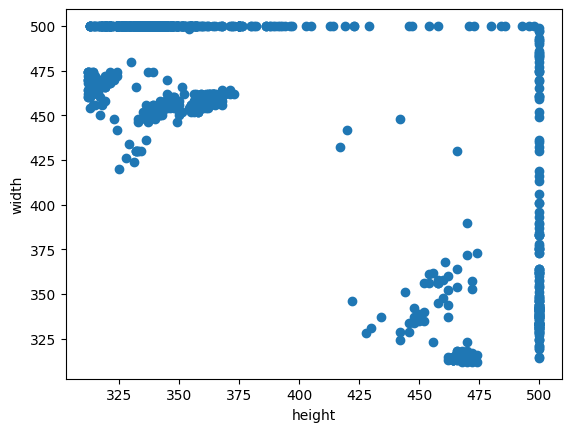

In [14]:
heights, widths = [], []

for path in all_jpg_paths:
    im = imageio.imread(path)
    heights.append(im.shape[0])
    widths.append(im.shape[1])

plt.scatter(heights, widths)
plt.xlabel('height')
plt.ylabel('width')
plt.show()

Create a label system to differentiate between different decades (allows us to do train_test_split easier)

In [15]:
class_label_mapping = {'1930s': 0,
                       '1940s': 1,
                       '1950s': 2,
                       '1960s': 3,
                       '1970s': 4}

df = pd.DataFrame(all_jpg_paths, columns=['paths'])
df['year'] = df['paths'].apply(lambda x: os.path.basename(os.path.dirname(x)))
df['labels'] = df['year'].map(class_label_mapping)
df.head()

,paths,year,labels
0,../DATA/HistoricalColor-ECCV2012/data/imgs/dec...,1960s,3
1,../DATA/HistoricalColor-ECCV2012/data/imgs/dec...,1960s,3
2,../DATA/HistoricalColor-ECCV2012/data/imgs/dec...,1960s,3
3,../DATA/HistoricalColor-ECCV2012/data/imgs/dec...,1960s,3
4,../DATA/HistoricalColor-ECCV2012/data/imgs/dec...,1960s,3


In [40]:
order = ['1930s', '1940s', '1950s', '1960s', '1970s']
df['decade'] = pd.Categorical(df['year'], categories=order, ordered=True)

In [ ]:
def calculate_brightness_contrast(image):
    gray_image = image.convert("L")
    img_array = np.array(gray_image)
    
    brightness = np.mean(img_array)
    
    contrast = np.std(img_array)
    
    return brightness, contrast

In [32]:
df[['brightness', 'contrast']] = df['paths'].apply(
    lambda x: calculate_brightness_contrast(Image.open(x))
).apply(pd.Series)

EDA Visualizations

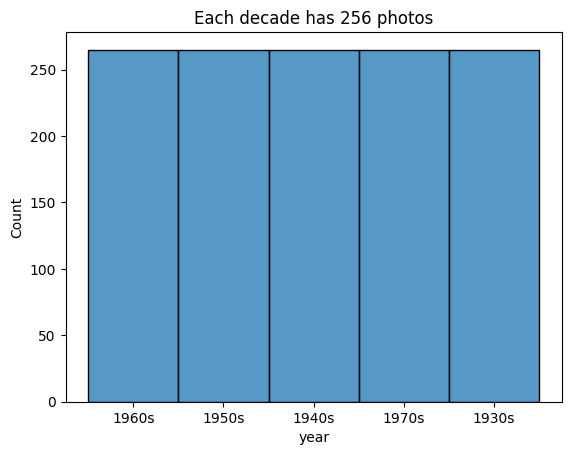

In [18]:
sns.histplot(df['year'])
plt.title('Each decade has 256 photos')
plt.savefig('../OUTPUT/eda1.png')

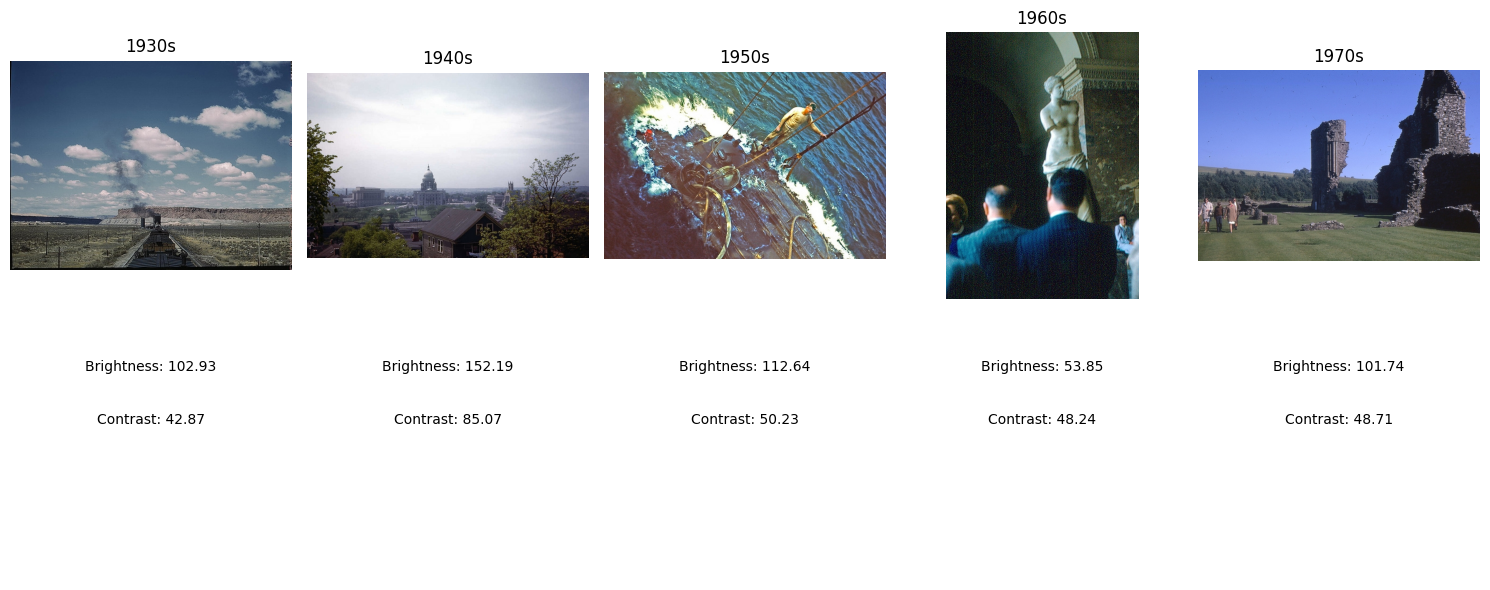

In [42]:
# Lookup dictionary
label_to_decade = {v: k for k, v in class_label_mapping.items()}

def calculate_brightness_contrast(image):
    # Convert image to grayscale
    gray_image = image.convert("L")
    img_array = np.array(gray_image)
    
    # Calculate brightness (mean pixel value)
    brightness = np.mean(img_array)
    
    # Calculate contrast (standard deviation of pixel values)
    contrast = np.std(img_array)
    
    return brightness, contrast

num_classes = len(class_label_mapping)
fig, axes = plt.subplots(2, num_classes, figsize=(3 * num_classes, 6))  # 2 rows: images + stats

for label in range(num_classes):
    sample_row = df[df['labels'] == label].sample(1).iloc[0]
    img_path = sample_row['paths']
    decade = label_to_decade[label]

    try:
        img = Image.open(img_path)
        brightness, contrast = calculate_brightness_contrast(img)

        axes[0, label].imshow(img)
        axes[0, label].axis('off')
        axes[0, label].set_title(f"{decade}")

        axes[1, label].text(0.5, 0.8, f"Brightness: {brightness:.2f}", ha='center', va='center', fontsize=10)
        axes[1, label].text(0.5, 0.6, f"Contrast: {contrast:.2f}", ha='center', va='center', fontsize=10)
        axes[1, label].axis('off')

    except Exception as e:
        axes[0, label].axis('off')
        axes[0, label].set_title(f"{decade}\n(Error)")
        axes[1, label].axis('off')

plt.tight_layout()
plt.savefig('../OUTPUT/eda2.png')
plt.show()

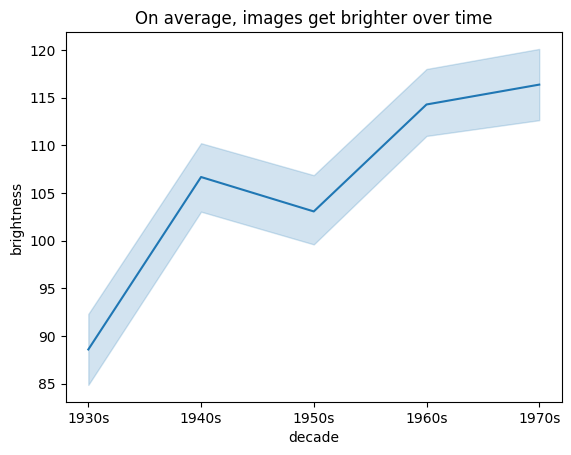

In [43]:
sns.lineplot(x='decade', y='brightness', data=df)
plt.title('On average, images get brighter over time')
plt.savefig('../OUTPUT/eda3.png')

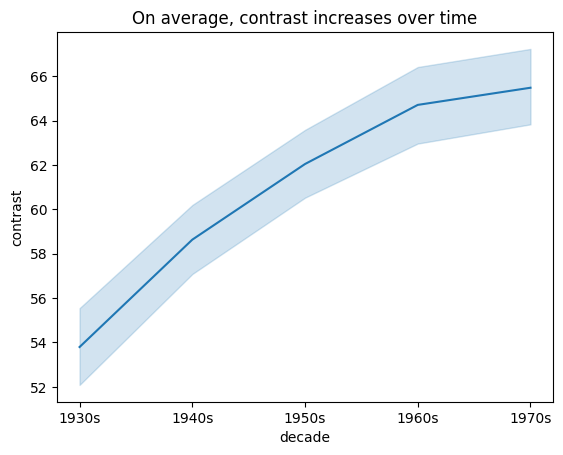

In [45]:
sns.lineplot(x='decade', y='contrast', data=df)
plt.title('On average, contrast increases over time')
plt.savefig('../OUTPUT/eda4.png')